## PROCESING

In [20]:
geotest_df = pd.read_csv('servicios.csv')

In [21]:
geotest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18673 entries, 0 to 18672
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   FECHA      18673 non-null  object
 1   HORA       18673 non-null  object
 2   UBICACION  16990 non-null  object
dtypes: object(3)
memory usage: 437.8+ KB


In [ ]:
geotest_df.dropna(inplace=True)

# Display the counts
geotest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17408 entries, 23 to 237112
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   FECHA      17408 non-null  datetime64[ns]
 1   HORA       17408 non-null  object        
 2   UBICACION  17408 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 544.0+ KB


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_4696\32432724.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geotest_df.dropna(inplace=True)


In [ ]:
geotest_df.head()

,FECHA,HORA,UBICACION
23,2023-10-26,22:34:00,PARA VALORIZACION DE FEMENINA
63,2023-10-27,08:09:00,MANANTIAL 507 LAGO COLONIA EL MANANTI...
69,2023-10-27,08:19:00,ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN ...
78,2023-10-27,08:41:00,CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...
84,2023-10-27,09:10:00,ELIAS FLORES SUR GARZA GARCIA OTE CO...


In [ ]:
# Ensure the 'COORDENADAS' column exists
geotest_df['COORDENADAS'] = geotest_df.get('COORDENADAS')

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_4696\3236194452.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geotest_df['COORDENADAS'] = geotest_df.get('COORDENADAS')


In [ ]:
geotest_df.shape

(17408, 4)

In [ ]:
# Configurar geolocalizador
geolocator = Nominatim(user_agent="MIATest/1.0", timeout=5)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1/20)

# Palabras irrelevantes o ruido
STOPWORDS = [
    r"\bCOLONIA\b", r"\bCORRODENAADAS\b", r"\bCOORDENADAS\b",
    r"\bAPODACA\b", r"\bNL\b", r"\bMUNICIPIO\b", r"\bIGLESIA\b",
    r"\bFOM\b", r"\bKM\b", r"\bPUENTE\b"
]

def limpiar_direccion(direccion):
    # Quitar palabras innecesarias
    for palabra in STOPWORDS:
        direccion = re.sub(palabra, '', direccion, flags=re.IGNORECASE)
    # Eliminar múltiples espacios y comas repetidas
    direccion = re.sub(r'\s+', ' ', direccion).strip()
    direccion = re.sub(r'[^\w\s#\-,]', '', direccion)
    # Añadir contexto geográfico si falta
    direccion = direccion.strip(', ')
    if 'apodaca' not in direccion.lower():
        direccion += ', Apodaca, Nuevo León, México'
    elif 'nuevo león' not in direccion.lower():
        direccion += ', Nuevo León, México'
    elif 'méxico' not in direccion.lower():
        direccion += ', México'
    return direccion

def reduce_address(address, level):
    parts = address.split(', ')
    return ', '.join(parts[level:]) if len(parts) > level else address

start_time = time.time()
counter = 0
total_addresses = len(geotest_df)

def geocode_address(address, existing_coords, folio, counter, total_addresses):
    if existing_coords is not None and existing_coords != (None, None):
        return existing_coords, counter
    try:
        direccion_limpia = limpiar_direccion(address)
        location = None
        for level in range(3):  # Intenta con niveles de reducción
            query = reduce_address(direccion_limpia, level)
            location = geocode(query)
            if location:
                break
        if location:
            result = {'lat': location.latitude, 'lon': location.longitude}
        else:
            print(f"⚠️ No se encontró dirección: {direccion_limpia} -> '{address}'")
            result = None
    except (GeocoderTimedOut, GeocoderUnavailable) as e:
        print(f"⏱️ Timeout/Unavailable en ubicacion {direccion_limpia}: {e}")
        result = None
    except Exception as e:
        print(f"❌ Error general en ubicacion {direccion_limpia}: {e}")
        result = None
    counter += 1
    print(f"No. {counter} ✅ Coordenada para ubicacion {direccion_limpia}: {result}")
    # Progreso y backup cada 50
    if counter % 50 == 0:
        elapsed = time.time() - start_time
        remaining = total_addresses - counter
        avg_time = elapsed / counter
        est_time_left = avg_time * remaining
        print(f"📊 {counter}/{total_addresses} procesados. "
              f"Tiempo estimado restante: {est_time_left/60:.2f} min")
        geotest_df.to_csv("geotest_backup.csv", index=False)
        print("💾 Backup guardado.")
    return result, counter

def apply_geocoding(row):
    global counter
    coord, counter = geocode_address(
        row['UBICACION'],
        row.get('COORDENADAS', None),
        row.get('FOLIO', row['UBICACION']),
        counter,
        total_addresses
    )
    return coord

# Aplicar geocodificación
geotest_df['COORDENADAS'] = geotest_df.apply(apply_geocoding, axis=1)

# Guardar resultado final
geotest_df.to_csv("geotest_backup.csv", index=False)
print("✅ Geocodificación finalizada. Backup guardado.")



No. 1 ✅ Coordenada para ubicacion PARA VALORIZACION DE FEMENINA, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 2 ✅ Coordenada para ubicacion MANANTIAL 507 LAGO EL MANANTIAL 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 3 ✅ Coordenada para ubicacion ANILLO PERIFERICO E 100D 49 MIGUEL ALEMAN PARQUE INDUSTRIAL KRONOS, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 4 ✅ Coordenada para ubicacion CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARCADAS CTO DE LAS ESPUELAS EX HACIENDA SANTA ROSA, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 5 ✅ Coordenada para ubicacion ELIAS FLORES SUR GARZA GARCIA OTE FUTURO, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 6 ✅ Coordenada para ubicacion PRIV RIO BRAVO 302 NUEVO 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 7 ✅ Coordenada para ubicacion FELIX LOZANO JUAREZ POBLADO SANTA ROSA SANT

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV DE LA CONCORDIA PASEO DE LOS PINOS PRADOS DE LOS PINOS 3, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local

No. 160 ✅ Coordenada para ubicacion AV DE LA CONCORDIA PASEO DE LOS PINOS PRADOS DE LOS PINOS 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 161 ✅ Coordenada para ubicacion MAKALU 123 MIRADOR DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 162 ✅ Coordenada para ubicacion AV DE LA CONCORDIA AV AFGANISTAN HACIENDA SANTA ISABEL 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 163 ✅ Coordenada para ubicacion AV DE LA CONCORDIA AV NUEVA LAS PUENTES NUEVO LAS PUENTES 5, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 164 ✅ Coordenada para ubicacion TERMINAL C AEROPUERTO 0 AEROPUERTO INTERNACIONAL MARIANO ESCOBEDO, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 165 ✅ Coordenada para ubicacion PERLA 265 JOYAS DEL PEDREGAL, Apodaca, Nuevo León, México: {'lat': 25.7323557, 'lon': -100.1673774}
No. 166 ✅ Coordenada para ubicacion GOLFO DE MEXICO 301 SAN ANDR

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV DE LA CONCORDIA BLVD SAN FRANCISCO CENTRO DE, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local\Programs\Py

No. 331 ✅ Coordenada para ubicacion AV DE LA CONCORDIA BLVD SAN FRANCISCO CENTRO DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 332 ✅ Coordenada para ubicacion ARTURO ROMO 123 y RAUL CABALLERO ALBERTA ESCAMILLA, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 333 ✅ Coordenada para ubicacion AV DE LA CONCORDIA MAPLE EBANOS, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 334 ✅ Coordenada para ubicacion CASIOPEA 442 COSMOPOLIS, Apodaca, Nuevo León, México: {'lat': 25.8277405, 'lon': -100.2469055}
No. 335 ✅ Coordenada para ubicacion HACIENDA LAS PALMAS 127 Y HACIENDA JACARANDAS LOS PINOS 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 336 ✅ Coordenada para ubicacion ABEDUL 151 y FRESNO ENRAMADA 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 337 ✅ Coordenada para ubicacion LAUREL 701 Y CAM REAL MEZQUITAL SANTA ROSA EBANOS 5, Apodaca, Nuevo León, Méxi

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV ALFONSO REYES AV DIEGO RIVERA QUINTA COLONIAL 1, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local\Programs

No. 4535 ✅ Coordenada para ubicacion AV ALFONSO REYES AV DIEGO RIVERA QUINTA COLONIAL 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 4536 ✅ Coordenada para ubicacion CANELO 833A ARBOLEDAS DE SANTA ROSA 4, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 4537 ✅ Coordenada para ubicacion RUBEN DARIO 815 SANTA CECILIA 5, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 4538 ✅ Coordenada para ubicacion JAZMIN 813 VALLE DE LAS FLORES, Apodaca, Nuevo León, México: {'lat': 25.7079488, 'lon': -100.1523162}
No. 4539 ✅ Coordenada para ubicacion IRLANDA INSPIRACION PASEO DE LAS PALMAS 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 4540 ✅ Coordenada para ubicacion VALLE DEL LAGO 128 VALLE DE HUINALA 4, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 4541 ✅ Coordenada para ubicacion HACIENDA LAS PALMAS HACIENDA LOS EBANOS HACIENDA LAS PALMAS 311 LOS PINOS 3, Apodac

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV DE LA CONCORDIA PASEO DE LOS PINOS PRADOS DE LOS PINOS 3, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local

No. 7597 ✅ Coordenada para ubicacion AV DE LA CONCORDIA PASEO DE LOS PINOS PRADOS DE LOS PINOS 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 7598 ✅ Coordenada para ubicacion ELIAS FLORES GARZA GARCIA MODERNO, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 7599 ✅ Coordenada para ubicacion ALDAMA OTE ZARAGOZA SUR CENTRO DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 7600 ✅ Coordenada para ubicacion CIPRES 808 ARBOLEDAS DE SANTA ROSA 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
📊 7600/17408 procesados. Tiempo estimado restante: 262.34 min
💾 Backup guardado.
No. 7601 ✅ Coordenada para ubicacion UTOPISTA AL AEROPUERTO AV ALMERIA ALMERIA, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 7602 ✅ Coordenada para ubicacion CARR A MIGUEL ALEMAN NAZRY HASBUN 25 74333011441136 100 20421350389205 DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV DE LA CONCORDIA MAPLE AV DE LA CONCORDIA DE, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local\Programs\Pyt

No. 8753 ✅ Coordenada para ubicacion AV DE LA CONCORDIA MAPLE AV DE LA CONCORDIA DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 8754 ✅ Coordenada para ubicacion HACIENDA DEL VERGEL HACIENDA LAS FLORES POLONIA JARDINES DE LOS PINOS 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 8755 ✅ Coordenada para ubicacion ANT CARR A ROMA E 10 BLVD CARLOS SALINAS DE GORTARI BLVD CARLOS SALINAS DE GORTARI DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 8756 ✅ Coordenada para ubicacion CHIPRE CUBA CUBA 117 NUEVO AMANECER 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 8757 ✅ Coordenada para ubicacion LOS FRESNOS LOS ALAMOS RIVERAS LOS FRESNOS 119 LAS GOLONDRINAS, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 8758 ✅ Coordenada para ubicacion ESTADO DE JALISCO 505 NORIA NORTE 39, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 8759 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV DE LA CONCORDIA BLVD SAN FRANCISCO CENTRO DE, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local\Programs\Py

No. 9204 ✅ Coordenada para ubicacion AV DE LA CONCORDIA BLVD SAN FRANCISCO CENTRO DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 9205 ✅ Coordenada para ubicacion AV CARTAGENA CRUZ POTENZADA HACIENDA LOS PINOS 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 9206 ✅ Coordenada para ubicacion MATAMOROS OTE ZARAGOZA SUR CENTRO DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 9207 ✅ Coordenada para ubicacion IBIS 218 LOS COLIBRIES, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 9208 ✅ Coordenada para ubicacion ESTACIONAMIENTO MI TIENDITA GASPAR CASTANO DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 9209 ✅ Coordenada para ubicacion RIO NILO 200 NUEVO 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 9210 ✅ Coordenada para ubicacion AV SAN FRANCISCO 253 EX HACIENDA SAN FRANCISCO 4, Apodaca, Nuevo León, México: {'lat': 25.7

RateLimiter caught an error, retrying (0/2 tries). Called with (*('DE LAS FUENTES AV MEXICO FUENTES DE SAN MIGUEL, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local\Programs\Pyt

No. 11082 ✅ Coordenada para ubicacion DE LAS FUENTES AV MEXICO FUENTES DE SAN MIGUEL, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 11083 ✅ Coordenada para ubicacion RIO NILO RIO ORINOCO NUEVO 5, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 11084 ✅ Coordenada para ubicacion HACIENDA LOS NOGALES HACIENDA LOS ROBLES LOS PINOS 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 11085 ✅ Coordenada para ubicacion PASEO DE LOS CANARIOS 207 LOS COLIBRIES, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 11086 ✅ Coordenada para ubicacion CARR A DULCES NOMBRE DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 11087 ✅ Coordenada para ubicacion FUTURO GARZA GARCIA OTE CENTRO DE UBICACION 25 781979 100 181076, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 11088 ✅ Coordenada para ubicacion AV DIEGO RIVERA ROTONDA DIEGO RIVERA QUINTA COLONI

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV JARDINES DE SAN ANDRES 114 JARDINES DE SAN ANDRES 1, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local\Prog

No. 13604 ✅ Coordenada para ubicacion AV JARDINES DE SAN ANDRES 114 JARDINES DE SAN ANDRES 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13605 ✅ Coordenada para ubicacion MIXTECA TOTONACA AZTECA 507 25 71653 100 17188 MONTEALBAN 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13606 ✅ Coordenada para ubicacion MILIMEX AV MIGUEL ALEMAN MILIMEX 1000 PARQUE INDUSTRIAL MILIMEX, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13607 ✅ Coordenada para ubicacion AZTECA 507 MONTEALBAN 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13608 ✅ Coordenada para ubicacion AV HACIENDA LAS MARGARITAS HACIENDA LOS LAURELES HACIENDA LOS LAURELES 853 HACIENDA LAS MARGARITAS 9, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13609 ✅ Coordenada para ubicacion VALLE DE POANAS 1000 VALLE DE LOS NOGALES 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV VILLA DE SAN CARLOS VILLA ALMERIA VILLAS DE SAN CARLOS 3, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local

No. 13673 ✅ Coordenada para ubicacion AV VILLA DE SAN CARLOS VILLA ALMERIA VILLAS DE SAN CARLOS 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13674 ✅ Coordenada para ubicacion BLVD ARCO VIAL LAT MIGUEL ALEMAN PROLOGIS PARK DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13675 ✅ Coordenada para ubicacion RIO ORINOCO 115 JARDINES DE HUINALA, Apodaca, Nuevo León, México: {'lat': 25.741891, 'lon': -100.1709174}
No. 13676 ✅ Coordenada para ubicacion LA ENCARNACION PALENQUE 25 73929 100 20158 ENCARNACION 343 VALLE DE HUINALA 2, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13677 ✅ Coordenada para ubicacion RIO ORINOCO RIO NILO NUEVO 5, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13678 ✅ Coordenada para ubicacion AV HECTOR CABALLERO TEQUILA NORIA NORTE 39, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13679 ✅ Coordenada para ubicacion AV DEL TRIUNF

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV DE LA CONCORDIA AV LAS PALMAS 25 784725 100 266477 VALLE DE LAS PALMAS 3, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebasti

No. 13742 ✅ Coordenada para ubicacion AV DE LA CONCORDIA AV LAS PALMAS 25 784725 100 266477 VALLE DE LAS PALMAS 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13743 ✅ Coordenada para ubicacion AV LUIS DONALDO COLOSIO ESPANA PARQUE INDUSTRIAL HUINALA, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13744 ✅ Coordenada para ubicacion CAMBOYANOS HONDURENOS 25 7275 100 17571 HONDUREÑOS 202 ROBERTO ESPINOZA, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13745 ✅ Coordenada para ubicacion A ANDRES GUAJARDO AV ANDRES GUAJARDO AV ANDRES GUAJARDO 315 PARQUE INDUSTRIAL 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13746 ✅ Coordenada para ubicacion A ANDRES GUAJARDO AV ANDRES GUAJARDO AV ANDRES GUAJARDO 315 PARQUE INDUSTRIAL 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 13747 ✅ Coordenada para ubicacion ALLENDE 505 ALDAMA COL U H INDEPENDENCIA CROC 1 http

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV VILLA DE SAN CARLOS CARR JUAREZ VILLAS DE SAN CARLOS 1 HORA 18 15, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppD

No. 14146 ✅ Coordenada para ubicacion AV VILLA DE SAN CARLOS CARR JUAREZ VILLAS DE SAN CARLOS 1 HORA 18 15, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 14147 ✅ Coordenada para ubicacion CIPRESAL 147 HACIENDA LOS ENCINOS, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 14148 ✅ Coordenada para ubicacion HIDALGO PTE ITURBIDE NTE ITURBIDE SUR ITURBIDE 153 CENTRO DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 14149 ✅ Coordenada para ubicacion AV CONCEPCION BARRAGAN CIPRES MARABU ENRAMADA 4, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 14150 ✅ Coordenada para ubicacion AV LAS PALMAS HUIZACHE PALO BLANCO PALO BLANCO 439 25 79425 100 26786 VALLE DE LAS PALMAS 4, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
📊 14150/17408 procesados. Tiempo estimado restante: 98.42 min
💾 Backup guardado.
No. 14151 ✅ Coordenada para ubicacion ALCATRAZ 608 HACIENDA LAS MARGAR

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV DE LA CONCORDIA BLVD SAN FRANCISCO DE, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Py

No. 15722 ✅ Coordenada para ubicacion AV DE LA CONCORDIA BLVD SAN FRANCISCO DE, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15723 ✅ Coordenada para ubicacion N 9 AV METROPLEX METROPLEX 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15724 ✅ Coordenada para ubicacion LIQUIDAMBAR 142 PASEO DE LA LOMA 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15725 ✅ Coordenada para ubicacion PERUANOS AV SUIZOS ROBERTO ESPINOZA, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15726 ✅ Coordenada para ubicacion AZUCENA 657 HACIENDA LAS MARGARITAS 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15727 ✅ Coordenada para ubicacion CIRUELO LIQUIDAMBAR PASEO DE LA LOMA 25 72129 100 141391 LIQUIDAMBAR 142 PASEO DE LA LOMA 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15728 ✅ Coordenada para ubicacion LAGO ARGENTINO 131 PRIVADAS DE SANTA 

RateLimiter caught an error, retrying (0/2 tries). Called with (*('AV ALFONSO REYES AV DIEGO RIVERA QUINTA COLONIAL 1, Apodaca, Nuevo León, México',), **{}).
Traceback (most recent call last):
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connectionpool.py", line 534, in _make_request
    response = conn.getresponse()
  File "d:\PredictivePresence\.venv\lib\site-packages\urllib3\connection.py", line 516, in getresponse
    httplib_response = super().getresponse()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 1374, in getresponse
    response.begin()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 318, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\http\client.py", line 279, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Sebastian\AppData\Local\Programs

No. 15783 ✅ Coordenada para ubicacion AV ALFONSO REYES AV DIEGO RIVERA QUINTA COLONIAL 1, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15784 ✅ Coordenada para ubicacion CAM REAL MEZQUITAL SANTA ROSA GARCETA 25 774075 100 239642 CAM REAL MEZQUITAL SANTA ROSA 1001 ARBADO SEC COLOMOS, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15785 ✅ Coordenada para ubicacion BAMBU GERTRUDIS BOCANEGRA BAMBU 131 ENRAMADA 3, Apodaca, Nuevo León, México: {'lat': 25.7871006, 'lon': -100.1850769}
No. 15786 ✅ Coordenada para ubicacion ARBOLEDAS DE SANTA ROSA 4, Apodaca, Nuevo León, México: {'lat': 25.8145524, 'lon': -100.2409898}
No. 15787 ✅ Coordenada para ubicacion FRESNOS 2, Apodaca, Nuevo León, México: {'lat': 25.7698276, 'lon': -100.2471441}
No. 15788 ✅ Coordenada para ubicacion CASAS REALES, Apodaca, Nuevo León, México: {'lat': 25.7830215, 'lon': -100.1945206}
No. 15789 ✅ Coordenada para ubicacion COSMOPOLIS, Apodaca, Nuevo León, México: {'lat':

C:\Users\Sebastian\AppData\Local\Temp\ipykernel_4696\931267187.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geotest_df['COORDENADAS'] = geotest_df.apply(apply_geocoding, axis=1)


✅ Geocodificación finalizada. Backup guardado.


## COORDINATE CLEANING

In [ ]:
geotest_df = pd.read_csv('geotest_backup2.csv')

NameError: name 'pd' is not defined

In [ ]:
geotest_df.tail()

NameError: name 'geotest_df' is not defined

In [ ]:
import ast  # Abstract Syntax Trees

# Convertir las cadenas a diccionarios reales
geotest_df['COORDENADAS'] = geotest_df['COORDENADAS'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extraer latitud y longitud
geotest_df['LATITUD'] = geotest_df['COORDENADAS'].apply(lambda x: x.get('lat') if isinstance(x, dict) else None)
geotest_df['LONGITUD'] = geotest_df['COORDENADAS'].apply(lambda x: x.get('lon') if isinstance(x, dict) else None)

# Ver resultado
geotest_df.head()


,FECHA,HORA,UBICACION,COORDENADAS,LATITUD,LONGITUD
0,2023-10-26,22:34:00,PARA VALORIZACION DE FEMENINA,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077
1,2023-10-27,08:09:00,MANANTIAL 507 LAGO COLONIA EL MANANTI...,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077
2,2023-10-27,08:19:00,ANILLO PERIFERICO E 100D KM 49 MIGUEL ALEMAN ...,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077
3,2023-10-27,08:41:00,CTO DE ESPADANA CTO DE LAS ESPUELAS DE LAS ARC...,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077
4,2023-10-27,09:10:00,ELIAS FLORES SUR GARZA GARCIA OTE CO...,"{'lat': 25.7871006, 'lon': -100.1850769}",25.787101,-100.185077


In [ ]:
geotest_df.describe()

,LATITUD,LONGITUD
count,17408.000000,17408.000000
mean,25.781373,-100.190200
std,0.021288,0.025709
min,25.697963,-100.267519
25%,25.787101,-100.185077
50%,25.787101,-100.185077
75%,25.787101,-100.185077
max,26.238436,-99.887300


In [ ]:
# Definir la coordenada a eliminar
coord_a_eliminar = {'lat': 25.7871006, 'lon': -100.1850769}

# Eliminar filas que coincidan exactamente
geotest_df = geotest_df[geotest_df['COORDENADAS'] != coord_a_eliminar]

# Verificar resultado
geotest_df.head()

,FECHA,HORA,UBICACION,COORDENADAS,LATITUD,LONGITUD
7,2023-10-27,10:21:00,TREVINO 1095 COLONIA CENTRO DE APODACA...,"{'lat': 25.7415877, 'lon': -100.1636989}",25.741588,-100.163699
9,2023-10-27,11:39:00,JAPON 203 COLONIA NUEVO AMANECER 2 APODACA NL,"{'lat': 25.7715892, 'lon': -100.2463403}",25.771589,-100.246340
17,2023-10-27,16:17:00,VIRIDIANA 123 COLONIA LOS MURALES APODAC...,"{'lat': 25.8019734, 'lon': -100.2225829}",25.801973,-100.222583
20,2023-10-27,18:35:00,A AV,"{'lat': 25.7555529, 'lon': -100.1969985}",25.755553,-100.196999
27,2023-10-28,10:15:00,HACIENDA DEL MEZQUITAL APODACA NL,"{'lat': 25.7493878, 'lon': -100.2317873}",25.749388,-100.231787


In [ ]:
geotest_df.describe()

,LATITUD,LONGITUD
count,5077.000000,5077.000000
mean,25.767461,-100.202644
std,0.035788,0.045255
min,25.697963,-100.267519
25%,25.743280,-100.247144
50%,25.769828,-100.197024
75%,25.787590,-100.164143
max,26.238436,-99.887300


In [ ]:
# Calculate the percentage of None values in 'LATITUD' column
percentage_none = (geotest_df['LATITUD'].isna().mean()) * 100

print("Percentage of None values in 'LATITUD' column:", percentage_none,'%')

Percentage of None values in 'LATITUD' column: 0.0 %


In [ ]:
geotest_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5077 entries, 7 to 17403
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        5077 non-null   object 
 1   HORA         5077 non-null   object 
 2   UBICACION    5077 non-null   object 
 3   COORDENADAS  5077 non-null   object 
 4   LATITUD      5077 non-null   float64
 5   LONGITUD     5077 non-null   float64
dtypes: float64(2), object(4)
memory usage: 277.6+ KB


In [ ]:
geotest_df.tail()

,FECHA,HORA,UBICACION,COORDENADAS,LATITUD,LONGITUD
17381,2025-05-25,13:00:00,LASALLISTAS 424 COLONIA EL CAMPANARIO APOD...,"{'lat': 25.7235277, 'lon': -100.1683663}",25.723528,-100.168366
17382,2025-05-25,13:07:00,EUCALIPTO 13 COLONIA ARBOLEDAS DEL MEZQUIT...,"{'lat': 25.7660816, 'lon': -100.2380871}",25.766082,-100.238087
17389,2025-05-25,15:21:00,HACIENDA SANTA LUCIA 245 COLONIA HACIENDA EL...,"{'lat': 25.729268, 'lon': -100.1407345}",25.729268,-100.140734
17393,2025-05-25,18:09:00,NEMESIO GARCIA NARANJO 219 COLONIA MOISE...,"{'lat': 25.8107212, 'lon': -100.2573947}",25.810721,-100.257395
17403,2025-05-26,08:36:00,CACERES 307 COLONIA VALLE DEL SALDUERO APO...,"{'lat': 25.8123857, 'lon': -100.2162626}",25.812386,-100.216263


In [ ]:
# Define a function to round time to the nearest quarter
def round_time_to_nearest_quarter(hr_reporte):
    # Convert time object to datetime object for easy manipulation
    dummy_date = datetime(2000, 1, 1)
    full_datetime = datetime.combine(dummy_date, hr_reporte)

    # Round to nearest 15 minutes
    # One way is to add 7 minutes and 30 seconds then truncate to the previous 15-minute block
    rounded_datetime = full_datetime + timedelta(minutes=7, seconds=30)
    # Subtract modulo-15 of minutes
    rounded_datetime -= timedelta(minutes=rounded_datetime.minute % 15,
                                   seconds=rounded_datetime.second,
                                   microseconds=rounded_datetime.microsecond)
    return rounded_datetime.time()

# Convert the 'HORA' column to datetime.time
geotest_df['HORA'] = pd.to_datetime(geotest_df['HORA']).dt.time

# Apply the rounding function to 'HORA'
geotest_df['HORA'] = geotest_df['HORA'].apply(round_time_to_nearest_quarter)

# Display the value counts of the rounded times
print(geotest_df['HORA'].value_counts())



HORA
19:15:00    84
20:00:00    82
21:30:00    79
20:15:00    76
21:45:00    75
            ..
06:15:00    26
05:15:00    25
04:45:00    25
07:00:00    23
05:30:00    19
Name: count, Length: 96, dtype: int64


In [ ]:
geotest_df = geotest_df.rename(columns={'UBICACION': 'DIR REPORTE'})

In [ ]:
geotest_df.head()

,FECHA,HORA,DIR REPORTE,COORDENADAS,LATITUD,LONGITUD
7,2023-10-27,10:15:00,TREVINO 1095 COLONIA CENTRO DE APODACA...,"{'lat': 25.7415877, 'lon': -100.1636989}",25.741588,-100.163699
9,2023-10-27,11:45:00,JAPON 203 COLONIA NUEVO AMANECER 2 APODACA NL,"{'lat': 25.7715892, 'lon': -100.2463403}",25.771589,-100.246340
17,2023-10-27,16:15:00,VIRIDIANA 123 COLONIA LOS MURALES APODAC...,"{'lat': 25.8019734, 'lon': -100.2225829}",25.801973,-100.222583
20,2023-10-27,18:30:00,A AV,"{'lat': 25.7555529, 'lon': -100.1969985}",25.755553,-100.196999
27,2023-10-28,10:15:00,HACIENDA DEL MEZQUITAL APODACA NL,"{'lat': 25.7493878, 'lon': -100.2317873}",25.749388,-100.231787


In [ ]:
geotest_df.describe()

,LATITUD,LONGITUD
count,5077.000000,5077.000000
mean,25.767461,-100.202644
std,0.035788,0.045255
min,25.697963,-100.267519
25%,25.743280,-100.247144
50%,25.769828,-100.197024
75%,25.787590,-100.164143
max,26.238436,-99.887300


In [ ]:
geotest_df.to_csv("geotest3.csv", index=False)

## FEATURE ENGINEERING

In [ ]:
geotest_df = pd.read_csv('geotest3.csv')

In [ ]:
geotest_df.drop('DIR REPORTE', axis=1, inplace=True)

In [ ]:
geotest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5077 entries, 0 to 5076
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        5077 non-null   object 
 1   HORA         5077 non-null   object 
 2   COORDENADAS  5077 non-null   object 
 3   LATITUD      5077 non-null   float64
 4   LONGITUD     5077 non-null   float64
dtypes: float64(2), object(3)
memory usage: 198.4+ KB


In [ ]:

# Assuming geotest_df is already loaded
print(f"Original row count: {len(geotest_df)}")

### --- Z-SCORE METHOD (FIXED) ---
# Compute Z-scores and assign original index
z_scores = zscore(geotest_df[['LATITUD', 'LONGITUD']])
z_df = pd.DataFrame(z_scores, columns=['LAT_Z', 'LON_Z'], index=geotest_df.index)

# Define a Z-score threshold (e.g., 3.0)
threshold = 3.0

# Create boolean mask
z_mask = (np.abs(z_df['LAT_Z']) < threshold) & (np.abs(z_df['LON_Z']) < threshold)

# Use the mask to filter original DataFrame
geotest_z_filtered = geotest_df[z_mask]

print(f"Rows after Z-score filtering: {len(geotest_z_filtered)}")

### --- IQR METHOD ---
def iqr_filter(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply IQR filtering to both columns
geotest_df = iqr_filter(geotest_df, 'LATITUD')
geotest_df = iqr_filter(geotest_df, 'LONGITUD')

print(f"Rows after IQR filtering: {len(geotest_df)}")


Original row count: 5077
Rows after Z-score filtering: 5072
Rows after IQR filtering: 5069


## CLUSTERING

In [ ]:
#INPUTS
n_clusters = 4  # For example, divide into 4 clusters

In [ ]:

def divide_samples_by_proximity(df, n_clusters):
    """
    Divides the samples into n clusters based on
    their geographic proximity.

    Parameters:
    - df: DataFrame containing the samples with
    'Latitud' and 'Longitud' columns.
    - n_clusters: The number of divisions
    (clusters) to create.

    Returns:
    - A list of DataFrames, each containing the samples
    for one cluster.
    """
    # Extract latitude and longitude for clustering
    coords = df[['LATITUD', 'LONGITUD']]

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).\
    fit(coords)
    df['Cluster'] = kmeans.labels_

    # Divide the DataFrame into n clusters and store each in a list
    cluster_dfs = [df[df['Cluster'] == i].drop('Cluster', axis=1) \
                   for i in range(n_clusters)]

    return cluster_dfs

# Example usage

geotest_df_clusters = divide_samples_by_proximity(geotest_df, n_clusters)

# Print the number of samples in each cluster
for i, cluster_df in enumerate(geotest_df_clusters):
    print(f"Cluster {i+1} has {len(cluster_df)} samples.")

Cluster 1 has 1179 samples.
Cluster 2 has 2379 samples.
Cluster 3 has 569 samples.
Cluster 4 has 942 samples.


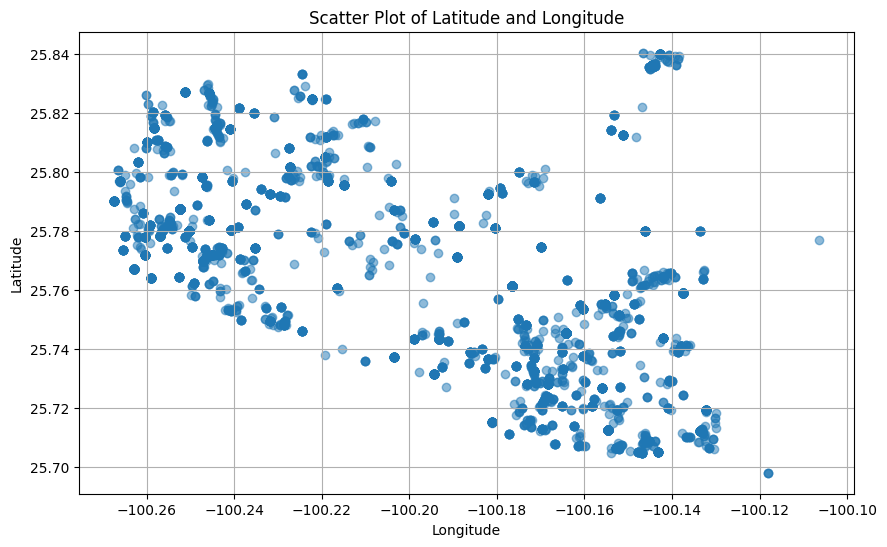

In [ ]:

# Graph 1: Scatter plot of latitude and longitude
plt.figure(figsize=(10, 6))
plt.scatter(geotest_df['LONGITUD'], geotest_df['LATITUD'], alpha=0.5)
plt.title('Scatter Plot of Latitude and Longitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


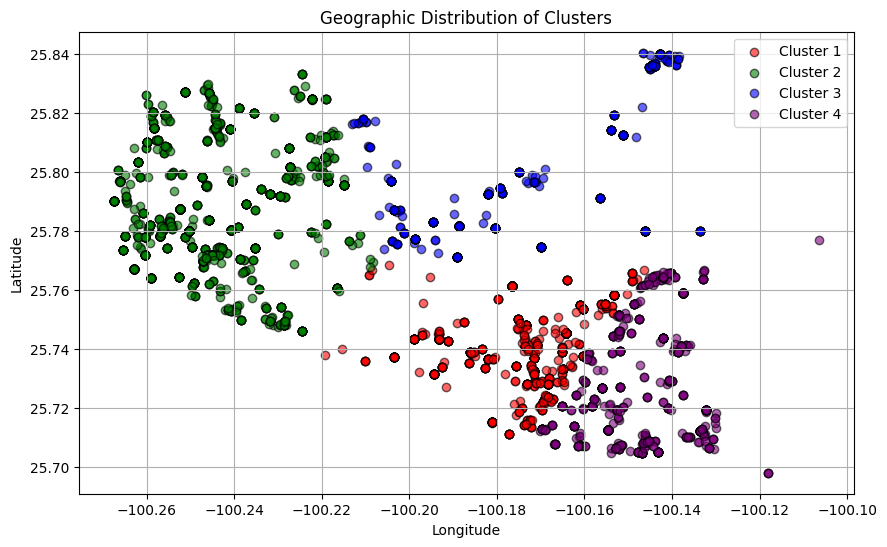

In [ ]:
# Set up the plot
plt.figure(figsize=(10, 6))

# Colors for each cluster
colors = ['red', 'green', 'blue', 'purple', 'orange', 'cyan', \
          'magenta', 'yellow', 'black', 'gray']

# Plot each cluster with a different color
for i, cluster_df in enumerate(geotest_df_clusters):
    plt.scatter(cluster_df['LONGITUD'], cluster_df['LATITUD'], \
                color=colors[i % len(colors)], label=f'Cluster {i+1}',\
                alpha=0.6, edgecolor='k')

plt.title('Geographic Distribution of Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
for i, cluster_df in enumerate(geotest_df_clusters):
    print(f"Cluster {i+1}:")
    print(cluster_df.head())  # Display the first few rows of the cluster
    print(f"Total samples in Cluster {i+1}: {len(cluster_df)}\n")


Cluster 1:
         FECHA      HORA                               COORDENADAS    LATITUD  \
0   2023-10-27  10:15:00  {'lat': 25.7415877, 'lon': -100.1636989}  25.741588   
3   2023-10-27  18:30:00  {'lat': 25.7555529, 'lon': -100.1969985}  25.755553   
10  2023-10-30  20:15:00   {'lat': 25.750001, 'lon': -100.1752985}  25.750001   
12  2023-10-31  10:30:00   {'lat': 25.7325419, 'lon': -100.171508}  25.732542   
14  2023-11-02  01:45:00   {'lat': 25.7325419, 'lon': -100.171508}  25.732542   

      LONGITUD  
0  -100.163699  
3  -100.196999  
10 -100.175298  
12 -100.171508  
14 -100.171508  
Total samples in Cluster 1: 1179

Cluster 2:
        FECHA      HORA                               COORDENADAS    LATITUD  \
1  2023-10-27  11:45:00  {'lat': 25.7715892, 'lon': -100.2463403}  25.771589   
2  2023-10-27  16:15:00  {'lat': 25.8019734, 'lon': -100.2225829}  25.801973   
4  2023-10-28  10:15:00  {'lat': 25.7493878, 'lon': -100.2317873}  25.749388   
5  2023-10-28  15:15:00  {'lat': 25

In [ ]:
for i, cluster_df in enumerate(geotest_df_clusters):
    print(f"Summary statistics for Cluster {i+1}:")
    print(cluster_df.info())
    print(cluster_df.describe())
    print("\n")


Summary statistics for Cluster 1:
<class 'pandas.core.frame.DataFrame'>
Index: 1179 entries, 0 to 5072
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        1179 non-null   object 
 1   HORA         1179 non-null   object 
 2   COORDENADAS  1179 non-null   object 
 3   LATITUD      1179 non-null   float64
 4   LONGITUD     1179 non-null   float64
dtypes: float64(2), object(3)
memory usage: 55.3+ KB
None
           LATITUD     LONGITUD
count  1179.000000  1179.000000
mean     25.742220  -100.174773
std       0.012446     0.013018
min      25.711107  -100.219201
25%      25.733756  -100.182118
50%      25.743280  -100.172934
75%      25.748327  -100.164143
max      25.768515  -100.146338


Summary statistics for Cluster 2:
<class 'pandas.core.frame.DataFrame'>
Index: 2379 entries, 1 to 5076
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0  

In [ ]:
def engineer_features(df):
    df_copy = df.copy()

    # Convert 'HORA' to datetime.time format and extract hour & minute
    df_copy['HORA'] = pd.to_datetime(df_copy['HORA'], format='%H:%M:%S', errors='coerce')

    df_copy['hour'] = df_copy['HORA'].dt.hour + df_copy['HORA'].dt.minute / 60
    df_copy['hour_sin'] = np.sin(2 * np.pi * df_copy['hour'] / 24)
    df_copy['hour_cos'] = np.cos(2 * np.pi * df_copy['hour'] / 24)

    df_copy.drop(['HORA', 'hour'], axis=1, inplace=True)

    # Parse 'FECHA' with explicit format
    df_copy['FECHA'] = pd.to_datetime(df_copy['FECHA'], format='%Y-%m-%d', errors='coerce')

    # Extract date components
    df_copy['year'] = df_copy['FECHA'].dt.year
    df_copy['month'] = df_copy['FECHA'].dt.month
    df_copy['day'] = df_copy['FECHA'].dt.day
    df_copy['dayofweek'] = df_copy['FECHA'].dt.dayofweek + 1
    df_copy['is_weekend'] = (df_copy['FECHA'].dt.dayofweek >= 5).astype(int)

    df_copy.drop('FECHA', axis=1, inplace=True)

    return df_copy



In [ ]:
def feature_division(clusters):
    """
    Applies feature engineering to each cluster and prepares data for modeling.

    Parameters:
    - clusters: A list of DataFrames, each representing a cluster.

    Returns:
    - A list of dictionaries, each containing the engineered features and targets for training, validation, and test sets for each cluster.
    - A list of MinMaxScaler instances used for scaling the target variables of each cluster.
    """

    cluster_data = []
    scalers = []  # List to store scalers for each cluster

    for i, df in enumerate(clusters):
        # Assume 'FECHA' and 'HR REPORTE' are the features and 'LATITUD', 'LONGITUD' are the targets
        X = df[['FECHA', 'HORA']]
        Y = df[['LATITUD', 'LONGITUD']]

        # Apply any necessary encoding or preprocessing
        X_encoded = engineer_features(X)  # Ensure this function is defined and suitable for your data

        # Split data into training, validation, and test sets (Example: 70%, 15%, 15%)
        X_train, X_temp, Y_train, Y_temp = train_test_split(X_encoded, Y, test_size=0.3, random_state=42)
        X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

        # Initialize a scaler for this cluster
        scaler = MinMaxScaler()

        # Normalize the target variables (Y)
        Y_train_scaled = scaler.fit_transform(Y_train)
        Y_val_scaled = scaler.transform(Y_val)
        Y_test_scaled = scaler.transform(Y_test)

        # Store the data and the scaler for this cluster
        cluster_data.append({
            'X_train': X_train, 'Y_train_scaled': Y_train_scaled,
            'X_val': X_val, 'Y_val_scaled': Y_val_scaled,
            'X_test': X_test, 'Y_test_scaled': Y_test_scaled,
        })
        scalers.append(scaler)  # Store the scaler used for this cluster

    return cluster_data, scalers

# Example usage
cluster_data, scalers = feature_division(geotest_df_clusters)



In [ ]:
for i, cluster_dict in enumerate(cluster_data):
    print(f"Cluster {i+1} - Features (X_train_df):")
    X_train_df = cluster_dict['X_train']  # Ensure this is a DataFrame
    print(X_train_df.head(), "\n")  # Using head() for brevity

    print(f"Cluster {i+1} - Targets (Y_train_scaled_df):")
    Y_train_scaled_df = pd.DataFrame(cluster_dict['Y_train_scaled'], columns=['LATITUD', 'LONGITUD'])
    print(Y_train_scaled_df.head(), "\n")  # Using head() for brevity



Cluster 1 - Features (X_train_df):
      hour_sin  hour_cos  year  month  day  dayofweek  is_weekend
3394  0.382683  0.923880  2024      6    8          6           1
3941  0.707107  0.707107  2024      9   19          4           0
1777 -0.707107 -0.707107  2024      2   27          2           0
3703 -0.500000  0.866025  2024      7   24          3           0
4105 -0.195090  0.980785  2024     10   31          4           0 

Cluster 1 - Targets (Y_train_scaled_df):
    LATITUD  LONGITUD
0  0.594463  0.773560
1  0.953987  0.983004
2  0.560435  0.363475
3  0.402916  0.613257
4  0.876392  0.599488 

Cluster 2 - Features (X_train_df):
      hour_sin  hour_cos  year  month  day  dayofweek  is_weekend
5018 -0.965926  0.258819  2025      5    9          5           0
2257 -0.831470 -0.555570  2024      3   22          5           0
2014  0.980785  0.195090  2024      3   10          7           1
3402 -0.321439 -0.946930  2024      6    8          6           1
4495  0.382683 -0.923880  2

In [ ]:
for i, cluster_dict in enumerate(cluster_data):
    print(f"Cluster {i+1} - Features (X_test_df):")
    # Assuming X_train contains 'FECHA' and 'HORA' after being processed by engineer_features
    # and is a DataFrame. Adjust according to your actual data structure.
    X_test_df = cluster_dict['X_test']  # This assumes X_train is a DataFrame
    print(X_test_df.describe(include='all'), "\n")

    print(f"Cluster {i+1} - Targets (Y_test_scaled_df):")
    # Assuming Y_train_scaled is a numpy array and needs to be converted to a DataFrame for description.
    # This assumes your targets were only 'LATITUD' and 'LONGITUD', adjust if your structure is different.
    Y_test_scaled_df = pd.DataFrame(cluster_dict['Y_test_scaled'], columns=['LATITUD', 'LONGITUD'])
    print(Y_test_scaled_df.describe(), "\n")


Cluster 1 - Features (X_test_df):
         hour_sin    hour_cos         year       month         day  \
count  177.000000  177.000000   177.000000  177.000000  177.000000   
mean    -0.168722   -0.060303  2024.022599    5.158192   15.909605   
std      0.668412    0.725687     0.553448    3.576732    9.180808   
min     -1.000000   -1.000000  2023.000000    1.000000    1.000000   
25%     -0.793353   -0.793353  2024.000000    2.000000    8.000000   
50%     -0.321439   -0.195090  2024.000000    4.000000   15.000000   
75%      0.382683    0.659346  2024.000000    8.000000   25.000000   
max      0.997859    1.000000  2025.000000   12.000000   31.000000   

        dayofweek  is_weekend  
count  177.000000  177.000000  
mean     3.745763    0.242938  
std      2.013533    0.430074  
min      1.000000    0.000000  
25%      2.000000    0.000000  
50%      4.000000    0.000000  
75%      5.000000    0.000000  
max      7.000000    1.000000   

Cluster 1 - Targets (Y_test_scaled_df):
     

In [ ]:
for i, cluster_dict in enumerate(cluster_data):
    print(f"Cluster {i+1} - Features (X_val_df):")
    # Assuming X_train contains 'FECHA' and 'HR REPORTE' after being processed by engineer_features
    # and is a DataFrame. Adjust according to your actual data structure.
    X_val_df = cluster_dict['X_val']  # This assumes X_train is a DataFrame
    print(X_val_df.describe(include='all'), "\n")

    print(f"Cluster {i+1} - Targets (Y_val_scaled_df):")
    # Assuming Y_train_scaled is a numpy array and needs to be converted to a DataFrame for description.
    # This assumes your targets were only 'LATITUD' and 'LONGITUD', adjust if your structure is different.
    Y_val_scaled_df = pd.DataFrame(cluster_dict['Y_val_scaled'], columns=['LATITUD', 'LONGITUD'])
    print(Y_val_scaled_df.describe(), "\n")


Cluster 1 - Features (X_val_df):
         hour_sin    hour_cos         year       month         day  \
count  177.000000  177.000000   177.000000  177.000000  177.000000   
mean    -0.206512   -0.058058  2023.943503    5.112994   15.553672   
std      0.676295    0.708539     0.485207    3.672487    8.800743   
min     -1.000000   -1.000000  2023.000000    1.000000    1.000000   
25%     -0.831470   -0.751840  2024.000000    2.000000    9.000000   
50%     -0.321439   -0.130526  2024.000000    4.000000   15.000000   
75%      0.321439    0.659346  2024.000000    7.000000   23.000000   
max      1.000000    1.000000  2025.000000   12.000000   31.000000   

        dayofweek  is_weekend  
count  177.000000  177.000000  
mean     3.943503    0.293785  
std      2.007705    0.456787  
min      1.000000    0.000000  
25%      2.000000    0.000000  
50%      4.000000    0.000000  
75%      6.000000    1.000000  
max      7.000000    1.000000   

Cluster 1 - Targets (Y_val_scaled_df):
       

In [ ]:
for i, cluster_dict in enumerate(cluster_data):
    print(f"Cluster {i+1} - Features (X_train_df):")
    # Assuming X_train contains 'FECHA' and 'HORA' after being processed by engineer_features
    # and is a DataFrame. Adjust according to your actual data structure.
    print(X_train_df.head(), "\n")

    print(f"Cluster {i+1} - Targets (Y_train_scaled_df):")
    # Assuming Y_train_scaled is a numpy array and needs to be converted to a DataFrame for description.
    # This assumes your targets were only 'LATITUD' and 'LONGITUD', adjust if your structure is different.
    print(Y_train_scaled_df.head(), "\n")


Cluster 1 - Features (X_train_df):
      hour_sin  hour_cos  year  month  day  dayofweek  is_weekend
3710  0.866025 -0.500000  2024      7   25          4           0
3575  0.896873 -0.442289  2024      6   18          2           0
1706  0.382683  0.923880  2024      2   25          7           1
731   0.946930  0.321439  2024      1    1          1           0
2930  0.130526  0.991445  2024      5    5          7           1 

Cluster 1 - Targets (Y_train_scaled_df):
    LATITUD  LONGITUD
0  0.236562  0.052575
1  0.419115  0.272943
2  0.885072  0.624264
3  0.156329  0.476572
4  0.885072  0.624264 

Cluster 2 - Features (X_train_df):
      hour_sin  hour_cos  year  month  day  dayofweek  is_weekend
3710  0.866025 -0.500000  2024      7   25          4           0
3575  0.896873 -0.442289  2024      6   18          2           0
1706  0.382683  0.923880  2024      2   25          7           1
731   0.946930  0.321439  2024      1    1          1           0
2930  0.130526  0.991445  2

## MODEL TRAINING

In [ ]:

def perform_grid_search_clusters(cluster_data):
    # Parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 150, 200],
        #'max_depth': [None, 10, 20, 30],
        'max_depth': [10, 15, 20],
        #'min_samples_split': [2, 5, 10],
        'min_samples_split': [5, 10, 15],
        #'min_samples_leaf': [1, 2, 4],
        'min_samples_leaf': [3, 4, 5],
        #'bootstrap': [True, False]
        'bootstrap': [True, False]
    }

    # Initialize a dictionary to store the best parameters for each cluster
    best_params_dict = {}

    for i, cluster in enumerate(cluster_data, start=1):
        print(f"Grid searching for cluster {i}")

        grid_search_lat = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
        grid_search_lat.fit(cluster['X_train'], cluster['Y_train_scaled'][:, 0])  # Assuming first column is latitude

        grid_search_lon = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
        grid_search_lon.fit(cluster['X_train'], cluster['Y_train_scaled'][:, 1])  # Assuming second column is longitude

        # Saving the best parameters directly with a modified key name
        best_params_dict[f'rf_lat_best_params_clust_{i}'] = grid_search_lat.best_params_
        best_params_dict[f'rf_lon_best_params_clust_{i}'] = grid_search_lon.best_params_

        print(f"Best Latitude Params for Cluster {i}: {grid_search_lat.best_params_}")
        print(f"Best Longitude Params for Cluster {i}: {grid_search_lon.best_params_}")

    return best_params_dict

# Example usage:
# Assuming cluster_data is already defined with 'X_train' and 'Y_train_scaled'
best_params_clusters = perform_grid_search_clusters(cluster_data)

# Printing best parameters for each cluster
for i in range(1, len(cluster_data) + 1):
    print(f"Cluster {i}:")
    print(f"  Best Latitude Parameters: {best_params_clusters[f'rf_lat_best_params_clust_{i}']}")
    print(f"  Best Longitude Parameters: {best_params_clusters[f'rf_lon_best_params_clust_{i}']}\n")


Grid searching for cluster 1
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Latitude Params for Cluster 1: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 200}
Best Longitude Params for Cluster 1: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 150}
Grid searching for cluster 2
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Latitude Params for Cluster 2: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 200}
Best Longitude Params for Cluster 2: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 200}
Grid searching for cluster 3
Fitting 3 folds for each of 162 candidates, totalling 486 fits
Fitting 3 folds for each of 

In [ ]:
'''
best_params_clusters = {'rf_lat_best_params_clust_1': {'bootstrap': True,
  'max_depth': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 15,
  'n_estimators': 200},
 'rf_lon_best_params_clust_1': {'bootstrap': True,
  'max_depth': 10,
  'min_samples_leaf': 4,
  'min_samples_split': 15,
  'n_estimators': 100},
 'rf_lat_best_params_clust_2': {'bootstrap': True,
  'max_depth': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 15,
  'n_estimators': 200},
 'rf_lon_best_params_clust_2': {'bootstrap': True,
  'max_depth': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 15,
  'n_estimators': 150},
 'rf_lat_best_params_clust_3': {'bootstrap': True,
  'max_depth': 10,
  'min_samples_leaf': 4,
  'min_samples_split': 15,
  'n_estimators': 150},
 'rf_lon_best_params_clust_3': {'bootstrap': True,
  'max_depth': 10,
  'min_samples_leaf': 4,
  'min_samples_split': 15,
  'n_estimators': 100}}
  '''

In [ ]:
import joblib
import os

def train_evaluate_and_export_models(cluster_data, best_params_clusters, fractions=[0.25, 0.5, 0.75, 1.0], export_dir='exported_models'):
    results = []

    # Create directory to save models if it doesn't exist
    os.makedirs(export_dir, exist_ok=True)

    for i, cluster in enumerate(cluster_data, start=1):
        cluster_result = {
            'train_rmse_lat': [],
            'val_rmse_lat': [],
            'train_rmse_lon': [],
            'val_rmse_lon': []
        }

        X_train_full = cluster['X_train']
        Y_train_scaled_full = pd.DataFrame(cluster['Y_train_scaled'], columns=['LATITUD', 'LONGITUD'])
        X_val = cluster['X_val']
        Y_val_scaled = pd.DataFrame(cluster['Y_val_scaled'], columns=['LATITUD', 'LONGITUD'])

        rf_lat_best_params = best_params_clusters[f'rf_lat_best_params_clust_{i}']
        rf_lon_best_params = best_params_clusters[f'rf_lon_best_params_clust_{i}']

        for fraction in fractions:
            print(f"Training fraction: {fraction}")
            if fraction < 1.0:
                X_train_frac, _, Y_train_scaled_frac, _ = train_test_split(
                    X_train_full, Y_train_scaled_full, train_size=fraction, random_state=42)
            else:
                X_train_frac = X_train_full
                Y_train_scaled_frac = Y_train_scaled_full

            # Train latitude model
            model_lat = RandomForestRegressor(**rf_lat_best_params)
            model_lat.fit(X_train_frac, Y_train_scaled_frac['LATITUD'])
            Y_pred_lat_train = model_lat.predict(X_train_frac)
            Y_pred_lat_val = model_lat.predict(X_val)
            train_rmse_lat = np.sqrt(mean_squared_error(Y_train_scaled_frac['LATITUD'], Y_pred_lat_train))
            val_rmse_lat = np.sqrt(mean_squared_error(Y_val_scaled['LATITUD'], Y_pred_lat_val))

            # Train longitude model
            model_lon = RandomForestRegressor(**rf_lon_best_params)
            model_lon.fit(X_train_frac, Y_train_scaled_frac['LONGITUD'])
            Y_pred_lon_train = model_lon.predict(X_train_frac)
            Y_pred_lon_val = model_lon.predict(X_val)
            train_rmse_lon = np.sqrt(mean_squared_error(Y_train_scaled_frac['LONGITUD'], Y_pred_lon_train))
            val_rmse_lon = np.sqrt(mean_squared_error(Y_val_scaled['LONGITUD'], Y_pred_lon_val))

            cluster_result['train_rmse_lat'].append(train_rmse_lat)
            cluster_result['val_rmse_lat'].append(val_rmse_lat)
            cluster_result['train_rmse_lon'].append(train_rmse_lon)
            cluster_result['val_rmse_lon'].append(val_rmse_lon)

            # Export models trained on full data (fraction == 1.0)
            print(f"Fractions to train on: {fractions}")

            if fraction == 1.0:
                lat_model_path = os.path.join(export_dir, f'cluster_{i}_model_lat.joblib')
                lon_model_path = os.path.join(export_dir, f'cluster_{i}_model_lon.joblib')
                joblib.dump(model_lat, lat_model_path)
                joblib.dump(model_lon, lon_model_path)
                print(f"Saved latitude model for cluster {i} at {lat_model_path}")
                print(f"Saved longitude model for cluster {i} at {lon_model_path}")

        results.append(cluster_result)

    return results, fractions



In [ ]:

# Call the training, evaluation, and export function
results, fractions = train_evaluate_and_export_models(cluster_data, best_params_clusters)

# If you want to load the saved models later or keep track of them:
trained_models = []

for i in range(1, len(cluster_data) + 1):
    lat_model_path = f'exported_models/cluster_{i}_model_lat.joblib'
    lon_model_path = f'exported_models/cluster_{i}_model_lon.joblib'

    # Load models from disk if needed (optional)
    model_lat = joblib.load(lat_model_path)
    model_lon = joblib.load(lon_model_path)

    trained_models.append((model_lat, model_lon))

print("Models trained, evaluated, exported, and loaded.")


Training fraction: 0.25
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Training fraction: 0.5
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Training fraction: 0.75
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Training fraction: 1.0
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Saved latitude model for cluster 1 at exported_models\cluster_1_model_lat.joblib
Saved longitude model for cluster 1 at exported_models\cluster_1_model_lon.joblib
Training fraction: 0.25
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Training fraction: 0.5
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Training fraction: 0.75
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Training fraction: 1.0
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Saved latitude model for cluster 2 at exported_models\cluster_2_model_lat.joblib
Saved longitude model for cluster 2 at exported_models\cluster_2_model_lon.joblib
Training fraction: 0.25
Fractions to train on: [0.25, 0.5, 0.75, 1.0]
Training fraction: 0.5
Fractions to train on: [0

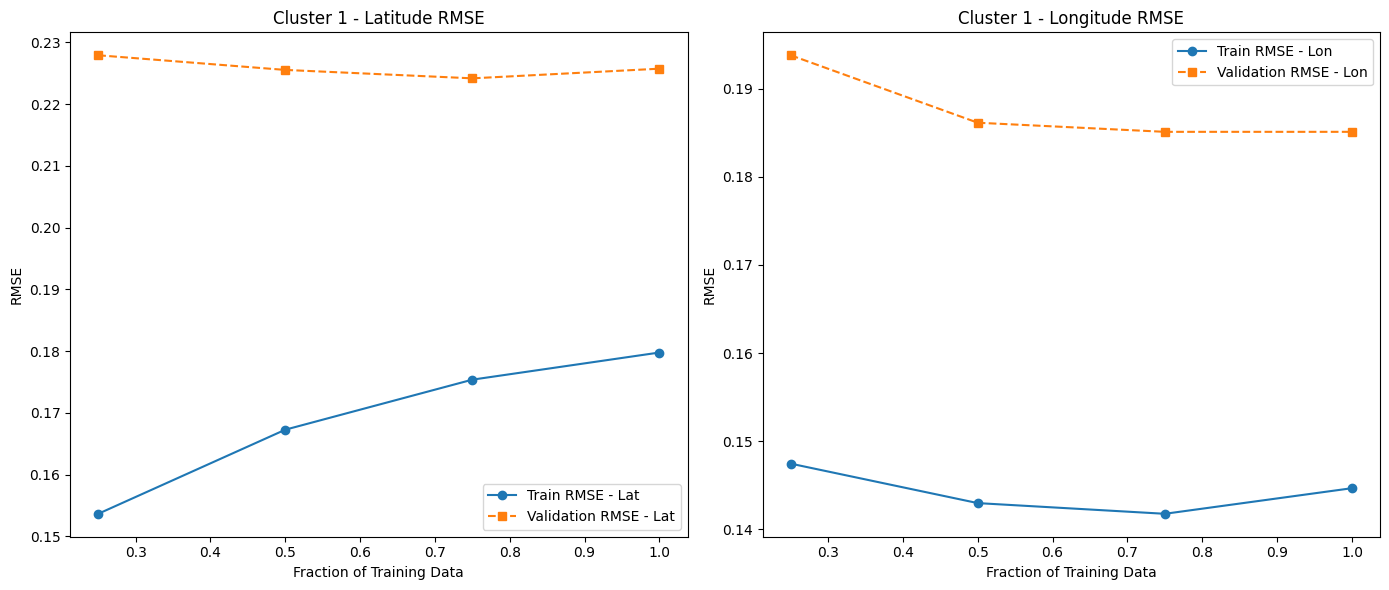

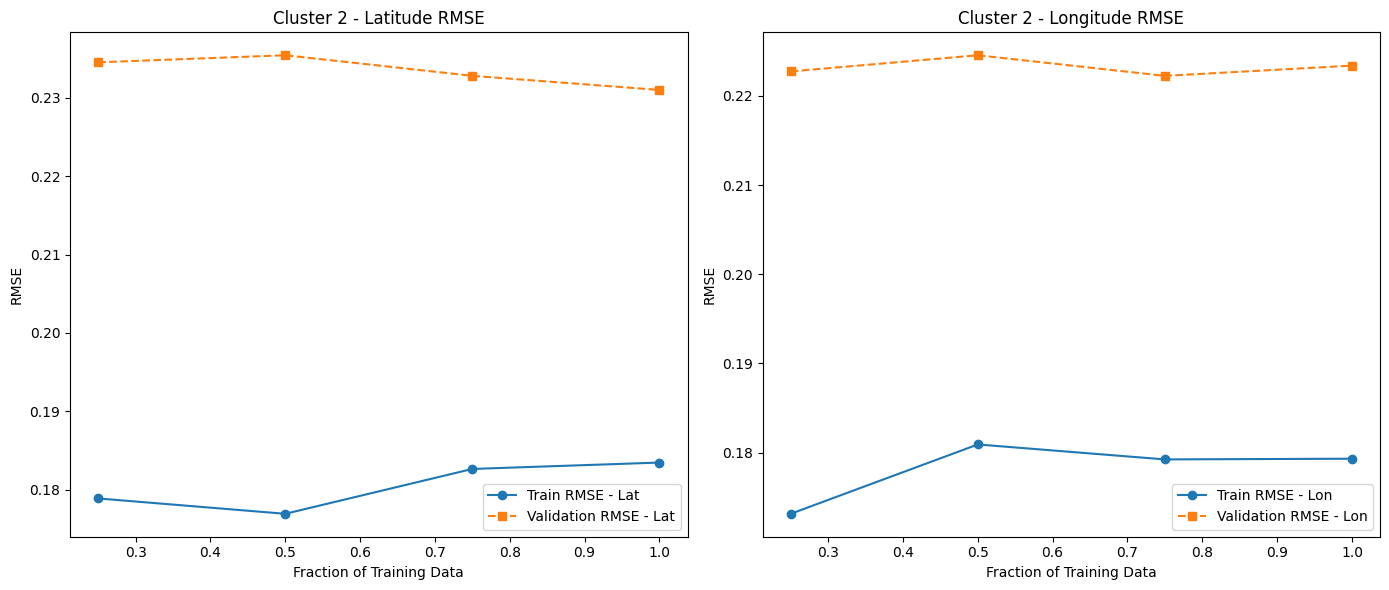

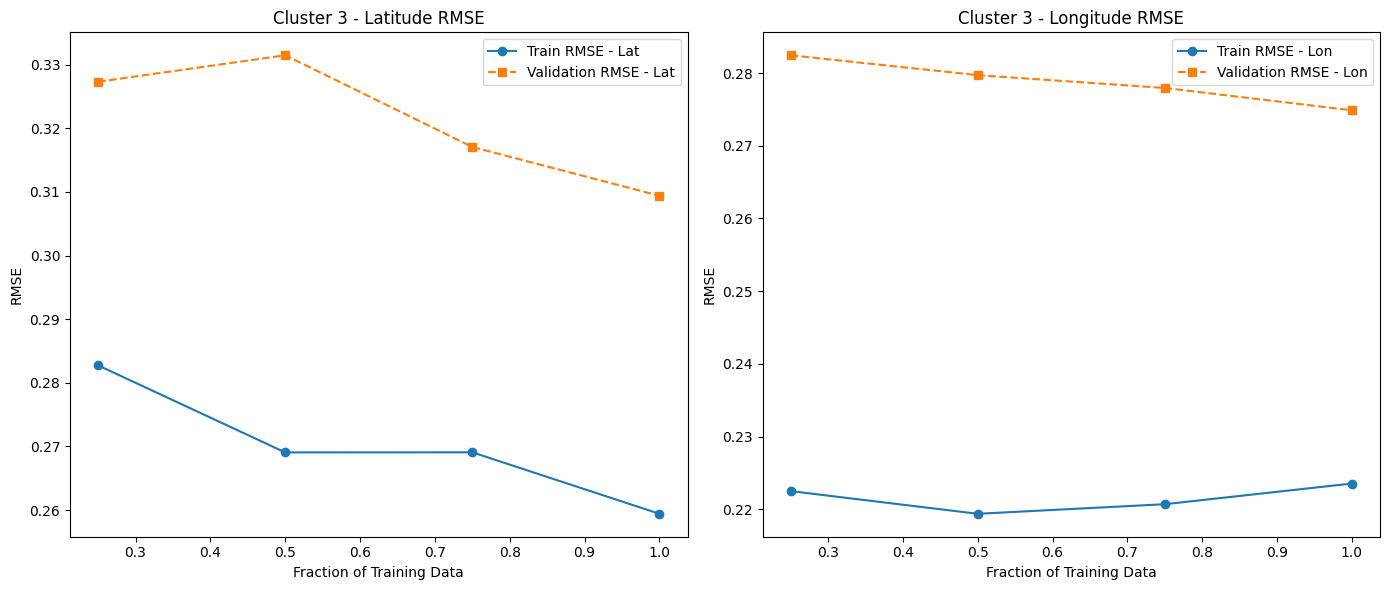

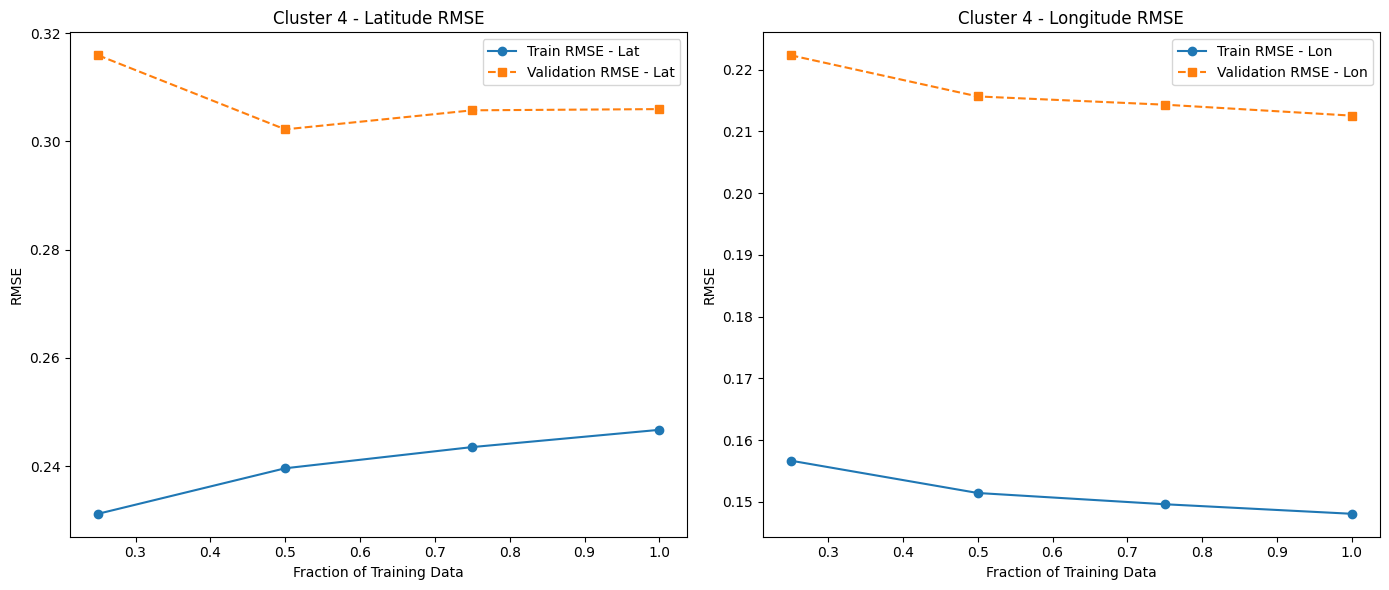

In [ ]:
def plot_rmse_results_per_cluster(results, fractions):

    for i, cluster_result in enumerate(results):
        plt.figure(figsize=(14, 6))

        # Latitude
        plt.subplot(1, 2, 1)
        plt.plot(fractions, cluster_result['train_rmse_lat'], 'o-', label='Train RMSE - Lat')
        plt.plot(fractions, cluster_result['val_rmse_lat'], 's--', label='Validation RMSE - Lat')
        plt.title(f'Cluster {i+1} - Latitude RMSE')
        plt.xlabel('Fraction of Training Data')
        plt.ylabel('RMSE')
        plt.legend()

        # Longitude
        plt.subplot(1, 2, 2)
        plt.plot(fractions, cluster_result['train_rmse_lon'], 'o-', label='Train RMSE - Lon')
        plt.plot(fractions, cluster_result['val_rmse_lon'], 's--', label='Validation RMSE - Lon')
        plt.title(f'Cluster {i+1} - Longitude RMSE')
        plt.xlabel('Fraction of Training Data')
        plt.ylabel('RMSE')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Plot the results
plot_rmse_results_per_cluster(results, fractions)


In [ ]:
for i, cluster in enumerate(cluster_data):
    print(f"Cluster {i+1}:")
    print(f"Training set size: {len(cluster['X_train'])}")
    print(f"Validation set size: {len(cluster['X_val'])}")
    print(f"Test set size: {len(cluster['X_test'])}")
    # Display shapes of the scaled target arrays to confirm their sizes
    print(f"Y_train_scaled shape: {cluster['Y_train_scaled'].shape}")
    print(f"Y_val_scaled shape: {cluster['Y_val_scaled'].shape}")
    print(f"Y_test_scaled shape: {cluster['Y_test_scaled'].shape}")
    print("-" * 40)


Cluster 1:
Training set size: 825
Validation set size: 177
Test set size: 177
Y_train_scaled shape: (825, 2)
Y_val_scaled shape: (177, 2)
Y_test_scaled shape: (177, 2)
----------------------------------------
Cluster 2:
Training set size: 1665
Validation set size: 357
Test set size: 357
Y_train_scaled shape: (1665, 2)
Y_val_scaled shape: (357, 2)
Y_test_scaled shape: (357, 2)
----------------------------------------
Cluster 3:
Training set size: 398
Validation set size: 85
Test set size: 86
Y_train_scaled shape: (398, 2)
Y_val_scaled shape: (85, 2)
Y_test_scaled shape: (86, 2)
----------------------------------------
Cluster 4:
Training set size: 659
Validation set size: 141
Test set size: 142
Y_train_scaled shape: (659, 2)
Y_val_scaled shape: (141, 2)
Y_test_scaled shape: (142, 2)
----------------------------------------


In [ ]:

def generate_time_intervals(date_str):
    """Generate 15-minute intervals for a given date."""
    intervals = []
    start_time = datetime.strptime(date_str, "%Y-%m-%d")
    for i in range(96):  # 96 intervals in a day (24 hours * 4 intervals per hour)
        intervals.append(start_time + timedelta(minutes=15 * i))
    return intervals

def convert_to_features(intervals):
    """Convert time intervals to features."""
    features = pd.DataFrame({
        'hour_sin': [np.sin(t.hour * (2 * np.pi / 24)) for t in intervals],
        'hour_cos': [np.cos(t.hour * (2 * np.pi / 24)) for t in intervals],
        'year': [t.year for t in intervals],
        'month': [t.month for t in intervals],
        'day': [t.day for t in intervals],
        'dayofweek': [t.weekday() for t in intervals],
        'is_weekend': [1 if t.weekday() in [5, 6] else 0 for t in intervals]
    })
    return features

def predict_coordinates_for_clusters(date_str, cluster_models, scalers):
    """
    Predict coordinates for all 15-minute intervals of a given date for each cluster,
    using a distinct scaler for each cluster. Also, concatenate latitude and longitude
    into a 'Coordenadas' string for each cluster.

    Parameters:
    - date_str: The date in "YYYY-MM-DD" format.
    - cluster_models: A list of tuples, each containing the trained latitude and longitude models for a cluster.
    - scalers: A list of MinMaxScaler instances used for inverse scaling predictions, one per cluster.

    Returns:
    - A DataFrame with the aggregated predictions for all clusters, including 'Coordenadas' columns.
    """
    intervals = generate_time_intervals(date_str)
    features = convert_to_features(intervals)

    aggregated_results = pd.DataFrame({
        'Day': date_str,
        'Time': [t.strftime("%H:%M") for t in intervals],
    })

    for i, ((model_lat, model_lon), scaler) in enumerate(zip(cluster_models, scalers), start=1):
        lat_pred_scaled = model_lat.predict(features)
        lon_pred_scaled = model_lon.predict(features)

        pred_scaled = np.vstack((lat_pred_scaled, lon_pred_scaled)).T
        pred_original_scale = scaler.inverse_transform(pred_scaled)

        aggregated_results[f'Cluster {i} Lat'] = pred_original_scale[:, 0]
        aggregated_results[f'Cluster {i} Lon'] = pred_original_scale[:, 1]

        # Concatenate latitude and longitude into 'Coordenadas' string using list comprehension
        aggregated_results[f'Coordenadas {i}'] = [
            f"{lat},{lon}" for lat, lon in zip(pred_original_scale[:, 0], pred_original_scale[:, 1])
        ]
    return aggregated_results



## PREDICTION

In [ ]:
# YYYY-MM-DD
date_str = "2025-05-31"

In [ ]:
# Assuming the scaler is fitted with the entire dataset's targets for latitude and longitude
Y_all_targets = np.vstack((cluster_data[0]['Y_train_scaled'], cluster_data[1]['Y_train_scaled'], cluster_data[2]['Y_train_scaled']))
scaler = MinMaxScaler().fit(Y_all_targets)

# Initialize the list with trained model tuples for each cluster
cluster_models = [
    (trained_models[0][0], trained_models[0][1]),  # Cluster 1 models (lat, lon)
    (trained_models[1][0], trained_models[1][1]),  # Cluster 2 models (lat, lon)
    (trained_models[2][0], trained_models[2][1]),   # Cluster 3 models (lat, lon)
    (trained_models[3][0], trained_models[3][1])   # Cluster 3 models (lat, lon)
]

# Now you can call predict_coordinates_for_clusters with the correct setup

aggregated_results = predict_coordinates_for_clusters(date_str, cluster_models, scalers)
print(aggregated_results.head())

NameError: name 'trained_models' is not defined

In [ ]:
aggregated_results.to_csv(f'pred_{date_str}.csv', index=False)